## 1. Introduction to Sequence Modeling <a name="introduction"></a>


Recurrent Neural Networks (RNNs) are designed to work with sequential data, making them ideal for:
- Natural Language Processing (NLP)
- Time Series Analysis
- Speech Recognition
- And more...

Unlike standard neural networks, RNNs have memory that captures information about what has been calculated previously, allowing them to make predictions based on both current and historical data.

![RNN Unfolded](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png)


## 2. Setting Up Our Environment <a name="setup"></a>


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(42)  # For reproducibility
import time

# Import Keras/TensorFlow libraries
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.optimizers import Adam

# Import scikit-learn utilities
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

## 3. Loading and Visualizing Stock Data <a name="data-loading"></a>


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd '/content/drive/MyDrive/ML 101/Practical'

/content/drive/MyDrive/ML 101/Practical


In [4]:
# Load the stock dataset
dataset = pd.read_csv('Dataset.csv')

dataset

,Date,Open,High,Low,Close,Volume
0,6/29/2010,19.000000,25.000000,17.540001,23.889999,18766300
1,6/30/2010,25.790001,30.420000,23.299999,23.830000,17187100
2,7/1/2010,25.000000,25.920000,20.270000,21.959999,8218800
3,7/2/2010,23.000000,23.100000,18.709999,19.200001,5139800
4,7/6/2010,20.000000,20.000000,15.830000,16.110001,6866900
...,...,...,...,...,...,...
1687,3/13/2017,244.820007,246.850006,242.779999,246.169998,3010700
1688,3/14/2017,246.110001,258.119995,246.020004,258.000000,7575500
1689,3/15/2017,257.000000,261.000000,254.270004,255.729996,4816600
1690,3/16/2017,262.399994,265.750000,259.059998,262.049988,7100400


In [5]:
# Remove the Date column since we're working with numerical data only
dataset = dataset.drop(['Date'], axis=1)
print("Dataset preview:")
display(dataset.head())

Dataset preview:


,Open,High,Low,Close,Volume
0,19.000000,25.00,17.540001,23.889999,18766300
1,25.790001,30.42,23.299999,23.830000,17187100
2,25.000000,25.92,20.270000,21.959999,8218800
3,23.000000,23.10,18.709999,19.200001,5139800
4,20.000000,20.00,15.830000,16.110001,6866900


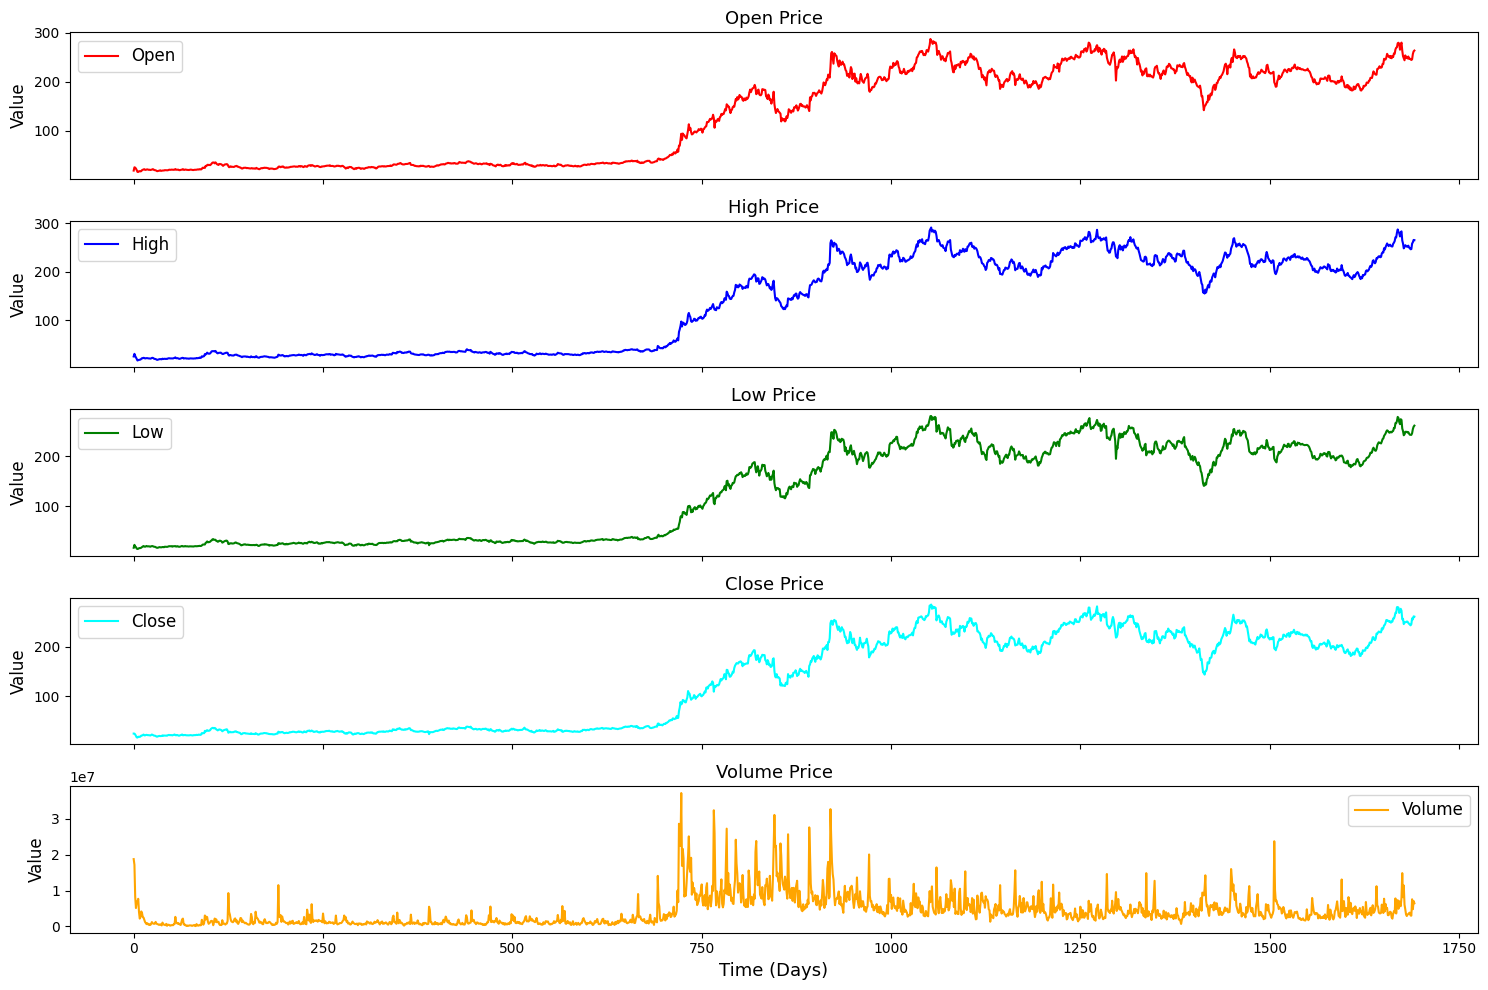

In [6]:
# Create a figure with subplots
fig, axes = plt.subplots(5, 1, figsize=(15, 10), sharex=True)
features = ['Open', 'High', 'Low', 'Close', 'Volume']
colors = ['red', 'blue', 'green', 'cyan', 'orange']

# Plot each feature in its own subplot
for i, (feature, color) in enumerate(zip(features, colors)):
    axes[i].plot(dataset[feature].values, color=color, label=feature)
    axes[i].set_ylabel('Value', fontsize=12)
    axes[i].set_title(f'{feature} Price', fontsize=13)
    axes[i].legend(fontsize=12)

# Set common x-axis label
plt.xlabel('Time (Days)', fontsize=13)
plt.tight_layout()
plt.show()

In [7]:
dataset.shape

(1692, 5)

## 4. Data Preprocessing for Sequential Models <a name="preprocessing"></a>

In [8]:
# For this example, we'll predict the 'Open' price of stocks using historical data.

# Select the 'Open' price as our target for prediction
target_data = dataset[['Open']]

# Normalize data between 0 and 1 (important for neural networks)
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

# Transform the dataset
normalized_features = scaler_features.fit_transform(dataset.values)
normalized_target = scaler_target.fit_transform(target_data)

print("Shape of normalized data:", normalized_features.shape)

Shape of normalized data: (1692, 5)


### Creating Sequences for Time Series Prediction


In [9]:
def create_sequences(data, target, sequence_length):
    """
    Create sequences of data for time series prediction.

    Parameters:
    - data: Normalized feature data
    - target: Normalized target data
    - sequence_length: Number of time steps to look back

    Returns:
    - X: Input sequences of shape (n_samples, sequence_length, n_features)
    - y: Target values of shape (n_samples,)
    """
    X, y = [], []

    for i in range(len(data) - sequence_length):
        # Create a sequence of 'sequence_length' time steps
        seq = data[i:i+sequence_length]
        # The target is the next value after the sequence
        target_value = target[i+sequence_length]

        X.append(seq)
        y.append(target_value)

    return np.array(X), np.array(y)

In [10]:
dataset.shape

(1692, 5)

In [11]:
# Define the number of previous time steps to use
sequence_length = 10  # Look back 10 days

# Create sequences
X, y = create_sequences(normalized_features, normalized_target, sequence_length)

print("Input shape (X):", X.shape)  # (n_samples, sequence_length, n_features)
print("Target shape (y):", y.shape)  # (n_samples, 1)

Input shape (X): (1682, 10, 5)
Target shape (y): (1682, 1)


### Splitting Data into Training, Validation, and Test Sets

In [12]:
# Split the data: 60% training, 20% validation, 20% testing
train_size = int(len(X) * 0.6)
valid_size = int(len(X) * 0.2)

# Training data
X_train, y_train = X[:train_size], y[:train_size]

# Validation data
X_valid, y_valid = X[train_size:train_size+valid_size], y[train_size:train_size+valid_size]

# Testing data
X_test, y_test = X[train_size+valid_size:], y[train_size+valid_size:]

print("Training data shape:", X_train.shape, y_train.shape)
print("Validation data shape:", X_valid.shape, y_valid.shape)
print("Testing data shape:", X_test.shape, y_test.shape)

Training data shape: (1009, 10, 5) (1009, 1)
Validation data shape: (336, 10, 5) (336, 1)
Testing data shape: (337, 10, 5) (337, 1)


In [13]:
X.shape

(1682, 10, 5)

## 5. Building and Training a Simple RNN Model <a name="simple-rnn"></a>

In [14]:
# Define model parameters
n_features = X.shape[2]  # Number of features
rnn_units = 3           # Number of hidden units in the RNN layer

# Build the SimpleRNN model
rnn_model = Sequential([
    SimpleRNN(rnn_units, activation='tanh', input_shape=(sequence_length, n_features)),
    Dense(1)  # Output layer with a single neuron for regression
])

# Compile the model with Adam optimizer and MSE loss
rnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Display the model summary
print("SimpleRNN Model Summary:")
rnn_model.summary()

SimpleRNN Model Summary:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 3)              │            27 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31 (124.00 B)

 Trainable params: 31 (124.00 B)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Visualization

# https://alexlenail.me/NN-SVG/index.html

# 3 input * 5 hidden_layer + 5 bais
# 5 input * 5 hidden_layer + 5 bais

In [ ]:
# Train the RNN model
start_time = time.time()

rnn_history = rnn_model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=100,
    batch_size=32,
    verbose=1
)
print(f"RNN Training Time: {time.time() - start_time:.2f} seconds")

### Visualizing RNN Training Progress

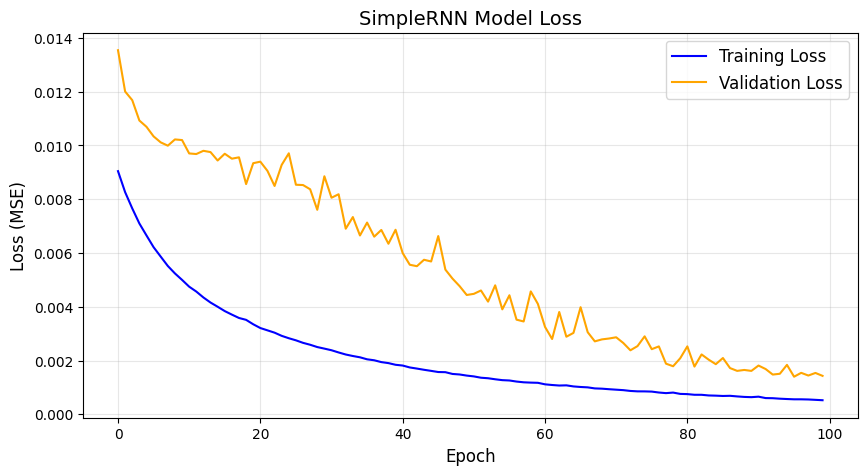

In [54]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(rnn_history.history['loss'], label='Training Loss', color='blue')
plt.plot(rnn_history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('SimpleRNN Model Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

### Making Predictions with the RNN Model

In [55]:
# Generate predictions on test data
rnn_predictions = rnn_model.predict(X_test)

# Inverse transform the predictions back to original scale
rnn_predictions = scaler_target.inverse_transform(rnn_predictions)
actual_values = scaler_target.inverse_transform(y_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [56]:
y_train.shape

(1009, 1)

In [57]:
train_values = scaler_target.inverse_transform(y_train)
valid_values = scaler_target.inverse_transform(y_valid)

In [58]:
actual_values.shape, rnn_predictions.shape

((337, 1), (337, 1))

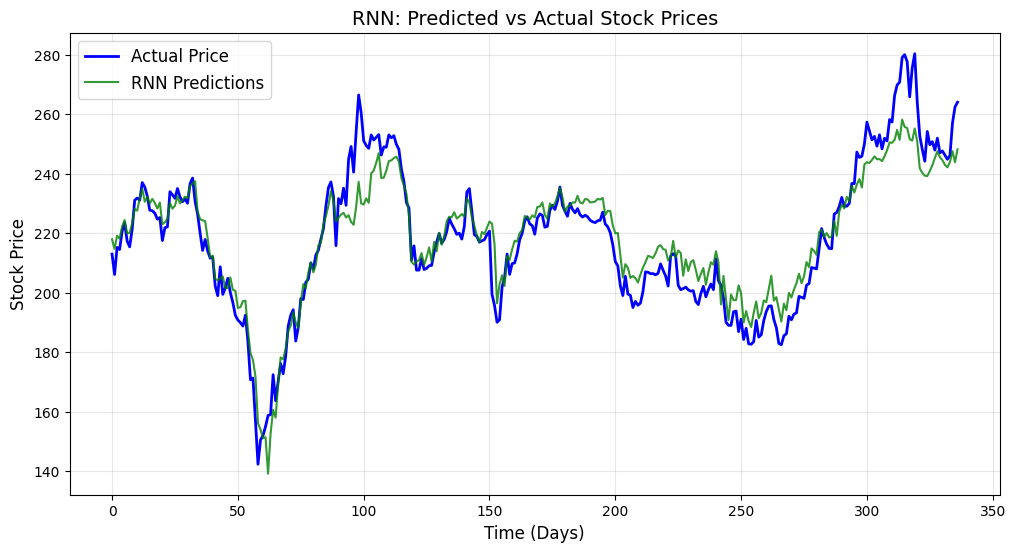

In [61]:
# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(actual_values, label='Actual Price', color='blue', linewidth=2)
plt.plot(rnn_predictions, label='RNN Predictions', color='green', linewidth=1.5, alpha=0.8)
plt.title('RNN: Predicted vs Actual Stock Prices', fontsize=14)
plt.xlabel('Time (Days)', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

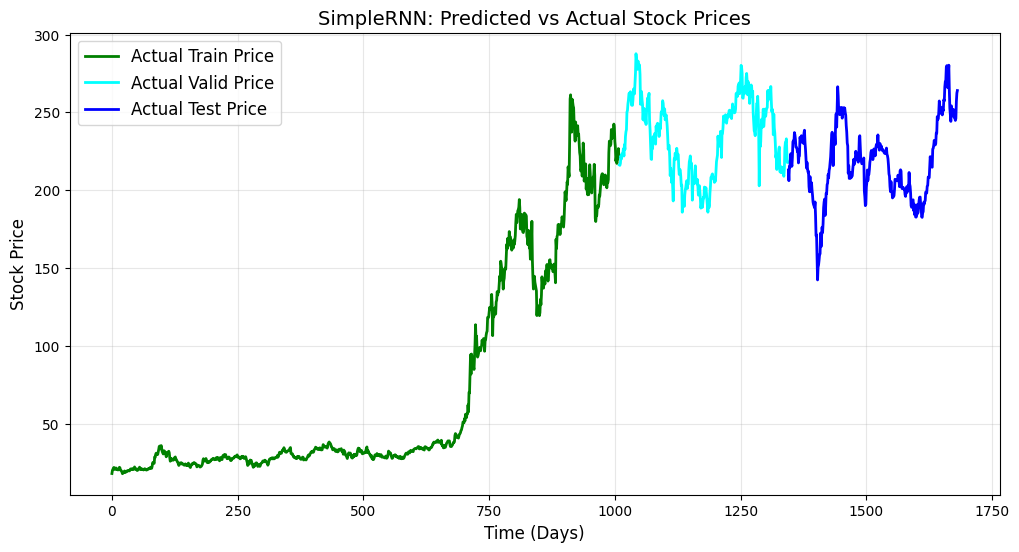

In [49]:
# Plot predictions vs actual values
plt.figure(figsize=(12, 6))

# Plotting training data
plt.plot(np.arange(0, len(train_values)), train_values, label='Actual Train Price', color='green', linewidth=2)

# Plotting validation data
plt.plot(np.arange(len(train_values), len(train_values) + len(valid_values)), valid_values, label='Actual Valid Price', color='cyan', linewidth=2)

# Plotting test data
plt.plot(np.arange(len(train_values) + len(valid_values), len(train_values) + len(valid_values) + len(actual_values)), actual_values, label='Actual Test Price', color='blue', linewidth=2)

# plt.plot(rnn_predictions, label='RNN Predictions', color='red', linewidth=1.5, alpha=0.8)
plt.title('SimpleRNN: Predicted vs Actual Stock Prices', fontsize=14)
plt.xlabel('Time (Days)', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()


In [64]:
# Evaluate RNN model performance
rnn_mse = mean_squared_error(actual_values, rnn_predictions)
rnn_rmse = np.sqrt(rnn_mse)
rnn_mae = mean_absolute_error(actual_values, rnn_predictions)

print(f"SimpleRNN Model Metrics:")
print(f"Mean Squared Error (MSE): {rnn_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rnn_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {rnn_mae:.4f}")

SimpleRNN Model Metrics:
Mean Squared Error (MSE): 64.7997
Root Mean Squared Error (RMSE): 8.0498
Mean Absolute Error (MAE): 6.1192


## 6. Building and Training an LSTM Model <a name="lstm-model"></a>

LSTMs are an advanced type of RNN designed to address the vanishing gradient problem that can occur in standard RNNs. They can remember patterns over longer sequences.

In [24]:
# Build the LSTM model
lstm_model = Sequential([
    LSTM(32, activation='tanh', input_shape=(sequence_length, n_features), return_sequences=True),
    LSTM(32, activation='tanh'),  # Second LSTM layer
    Dense(1)  # Output layer
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
lstm_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Display the model summary
print("LSTM Model Summary:")
lstm_model.summary()

LSTM Model Summary:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 32)         │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,217 (51.63 KB)

 Trainable params: 13,217 (51.63 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
X_train.shape

(1009, 10, 5)

In [37]:
# Train the LSTM model
start_time = time.time()

lstm_history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=5,
    batch_size=32,
    verbose=1
)

print(f"LSTM Training Time: {time.time() - start_time:.2f} seconds")

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 5.2587e-04 - mae: 0.0133 - val_loss: 0.0014 - val_mae: 0.0302
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.1428e-04 - mae: 0.0132 - val_loss: 0.0017 - val_mae: 0.0348
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.4505e-04 - mae: 0.0126 - val_loss: 0.0015 - val_mae: 0.0314
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.3435e-04 - mae: 0.0128 - val_loss: 0.0016 - val_mae: 0.0307
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.6977e-04 - mae: 0.0133 - val_loss: 0.0015 - val_mae: 0.0325
LSTM Training Time: 3.28 seconds


### Visualizing LSTM Training Progress

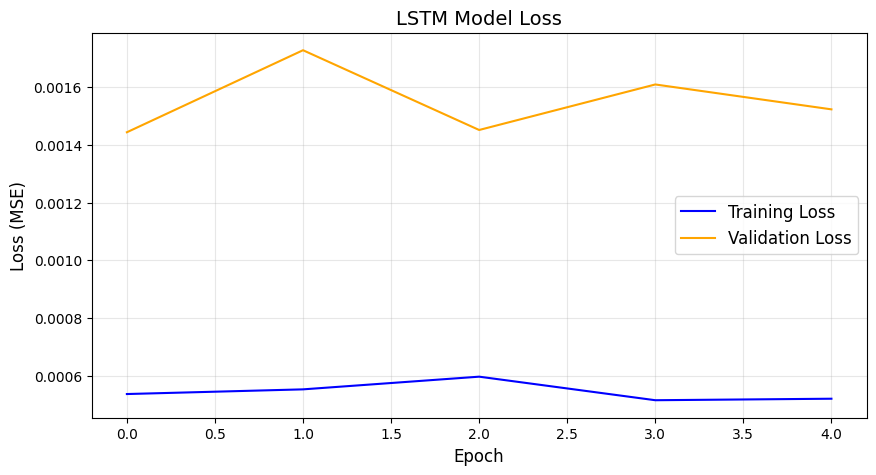

In [38]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(lstm_history.history['loss'], label='Training Loss', color='blue')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('LSTM Model Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

### Making Predictions with the LSTM Model

In [39]:
# Generate predictions on test data
lstm_predictions = lstm_model.predict(X_test)

# Inverse transform the predictions back to original scale
lstm_predictions = scaler_target.inverse_transform(lstm_predictions)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


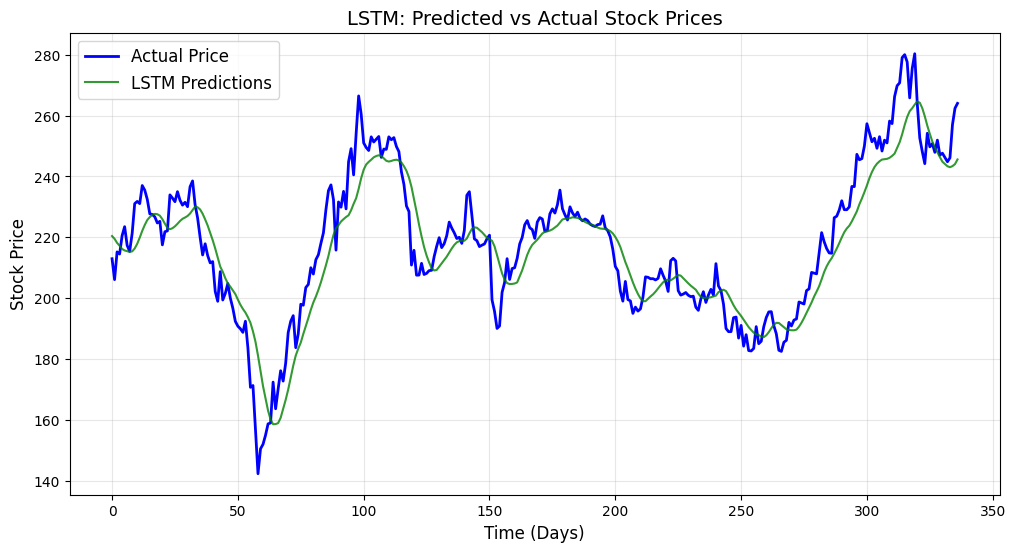

In [40]:
# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(actual_values, label='Actual Price', color='blue', linewidth=2)
plt.plot(lstm_predictions, label='LSTM Predictions', color='green', linewidth=1.5, alpha=0.8)
plt.title('LSTM: Predicted vs Actual Stock Prices', fontsize=14)
plt.xlabel('Time (Days)', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

In [63]:
# Evaluate LSTM model performance
lstm_mse = mean_squared_error(actual_values, lstm_predictions)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mae = mean_absolute_error(actual_values, lstm_predictions)

print(f"LSTM Model Metrics:")
print(f"Mean Squared Error (MSE): {lstm_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {lstm_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {lstm_mae:.4f}")

LSTM Model Metrics:
Mean Squared Error (MSE): 99.2746
Root Mean Squared Error (RMSE): 9.9637
Mean Absolute Error (MAE): 7.8098


## 7. Comparing Model Performance <a name="model-comparison"></a>

In [65]:
# Create a DataFrame to compare model performance
model_comparison = pd.DataFrame({
    'SimpleRNN': [rnn_mse, rnn_rmse, rnn_mae],
    'LSTM': [lstm_mse, lstm_rmse, lstm_mae]
}, index=['MSE', 'RMSE', 'MAE'])

print("Model Performance Comparison:")
display(model_comparison)

Model Performance Comparison:


,SimpleRNN,LSTM
MSE,64.799678,99.274557
RMSE,8.049825,9.963662
MAE,6.119166,7.809782


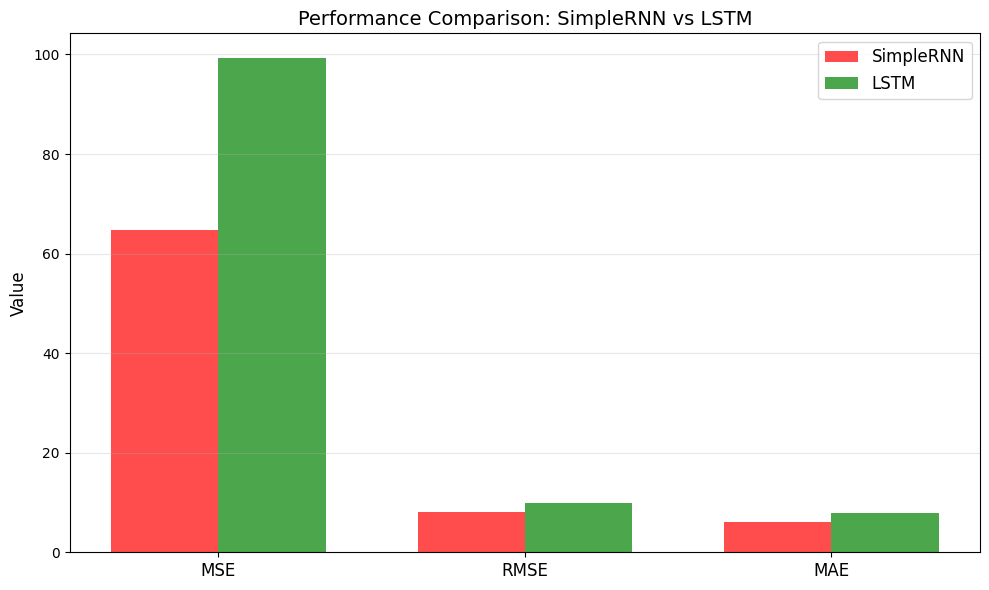

In [66]:
# Create a bar chart to visualize performance comparison
metrics = ['MSE', 'RMSE', 'MAE']
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rnn_bars = ax.bar(x - width/2, model_comparison['SimpleRNN'], width, label='SimpleRNN', color='red', alpha=0.7)
lstm_bars = ax.bar(x + width/2, model_comparison['LSTM'], width, label='LSTM', color='green', alpha=0.7)

ax.set_title('Performance Comparison: SimpleRNN vs LSTM', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Combining Model Predictions <a name="combined-models"></a>

Sometimes, combining predictions from multiple models can yield better results than any single model alone.

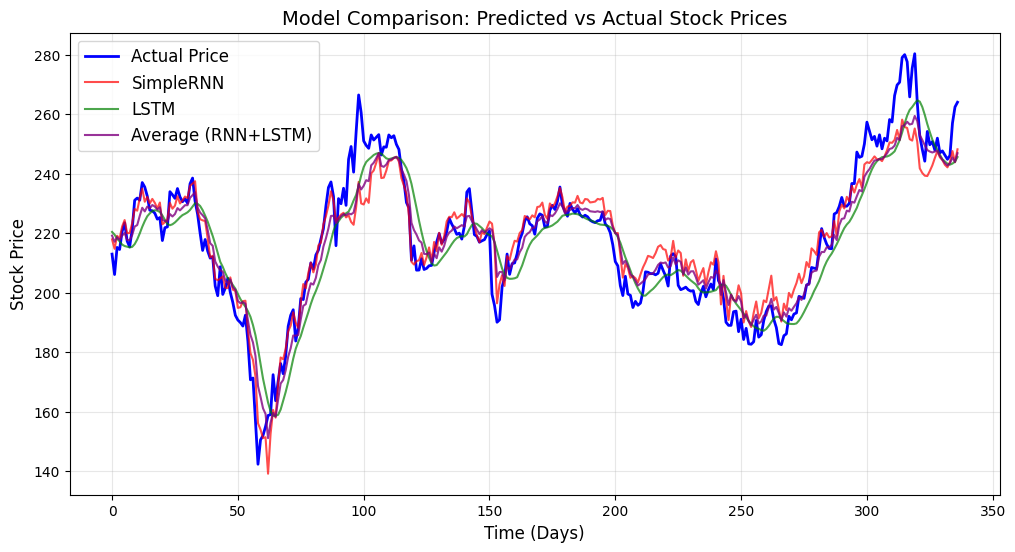

In [67]:
# Plot all predictions together
plt.figure(figsize=(12, 6))
plt.plot(actual_values, label='Actual Price', color='blue', linewidth=2)
plt.plot(rnn_predictions, label='SimpleRNN', color='red', linewidth=1.5, alpha=0.7)
plt.plot(lstm_predictions, label='LSTM', color='green', linewidth=1.5, alpha=0.7)

# Calculate and plot the average of both models
average_predictions = (rnn_predictions + lstm_predictions) / 2
plt.plot(average_predictions, label='Average (RNN+LSTM)', color='purple', linewidth=1.5, alpha=0.8)

plt.title('Model Comparison: Predicted vs Actual Stock Prices', fontsize=14)
plt.xlabel('Time (Days)', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

In [68]:
# Evaluate the average model
avg_mse = mean_squared_error(actual_values, average_predictions)
avg_rmse = np.sqrt(avg_mse)
avg_mae = mean_absolute_error(actual_values, average_predictions)

print(f"Combined Model (Average) Metrics:")
print(f"Mean Squared Error (MSE): {avg_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {avg_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {avg_mae:.4f}")

# Add the combined model to our comparison
model_comparison['Average'] = [avg_mse, avg_rmse, avg_mae]
print("\nUpdated Model Performance Comparison:")
display(model_comparison)

Combined Model (Average) Metrics:
Mean Squared Error (MSE): 62.8681
Root Mean Squared Error (RMSE): 7.9289
Mean Absolute Error (MAE): 6.0075

Updated Model Performance Comparison:


,SimpleRNN,LSTM,Average
MSE,64.799678,99.274557,62.868091
RMSE,8.049825,9.963662,7.928940
MAE,6.119166,7.809782,6.007462


## Key Takeaways

1. **Recurrent Neural Networks (RNNs)**:
   - Good for short-term patterns
   - Simpler architecture with fewer parameters
   - Faster training time
   - May suffer from vanishing gradient problem on long sequences

2. **Long Short-Term Memory (LSTM) Networks**:
   - Better at capturing long-term dependencies
   - More complex architecture with more parameters
   - Slower training time but typically better performance

3. **Sequence Modeling**:
   - Time series prediction requires looking at patterns over time
   - Feature normalization is crucial for neural network stability
   - The sequence length (lookback period) is an important hyperparameter

4. **Model Evaluation**:
   - Always split data into training, validation, and test sets
   - Use appropriate metrics: MSE, RMSE, MAE
   - Consider ensemble methods (like averaging predictions) for improved performance